# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): None

Enrollment Status (109A, 121A, 209A, or E109A): AC209A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

import seaborn as sns

D:\ProgramData\Anaconda3\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
dtype_dict = {"season":int, "month":int, "holiday":int, "day_of_week": int, "workingday":int, "weather":int, \
             "temp":float, "atemp":float, "humidity":float, "windspeed": float, "count":int}

In [3]:
bike_train_df = pd.read_csv('data/Bikeshare_train.csv', low_memory=False, index_col=0, dtype=dtype_dict)
bike_test_df = pd.read_csv('data/Bikeshare_test.csv', low_memory=False, index_col=0, dtype=dtype_dict)
bike_train_df.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2,5,0,2,1,2,24.0,26.0,76.5833,0.118167,6073
1,4,12,0,2,1,1,15.0,19.0,73.3750,0.174129,6606
2,2,6,0,4,1,1,26.0,28.0,56.9583,0.253733,7363
3,4,12,0,0,0,1,0.0,4.0,58.6250,0.169779,2431
4,3,9,0,3,1,3,23.0,23.0,91.7083,0.097021,1996


In [4]:
bike_count_train = bike_train_df['count'].values
bike_count_test = bike_test_df['count'].values

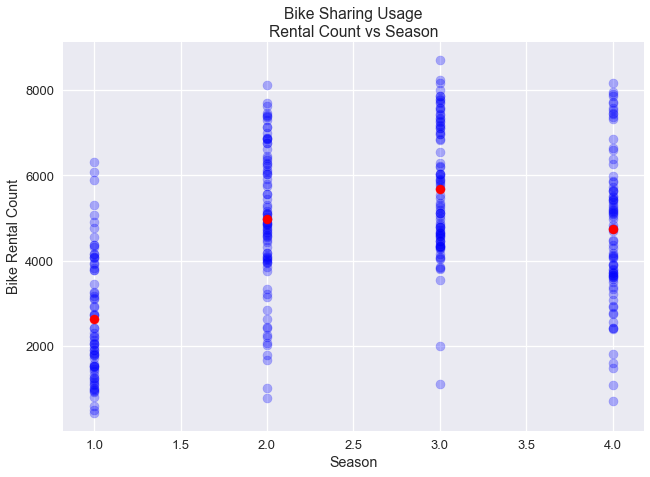

In [5]:
season = bike_train_df['season'].values

sns.set_context('talk')
plt.scatter(season, bike_count_train, color='blue', alpha=0.3, label='data')
for s in range(1, 5):
    plt.scatter(s, bike_count_train[season==s].mean(), color='red', label='mean')
plt.xlabel('Season')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Season')
plt.show()

The number of bike rentals seems to have some relationship with the season. Rental count is higher in Fall (s=3) than in Spring (s=1)

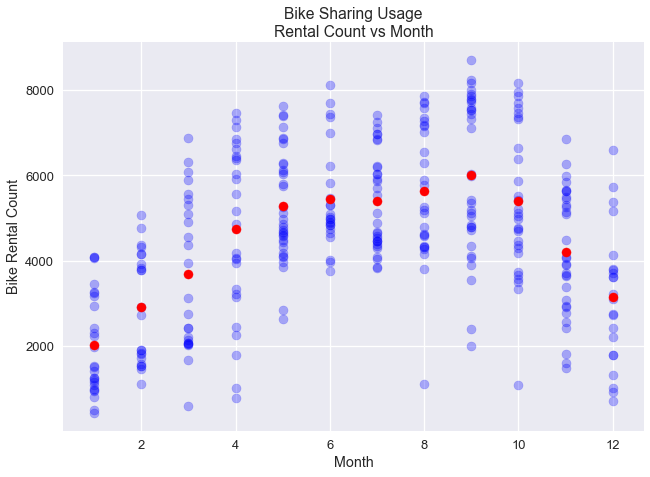

In [6]:
month = bike_train_df['month'].values

sns.set_context('talk')
plt.scatter(month, bike_count_train, color='blue', alpha=0.3)
for s in range(1, 13):
    plt.scatter(s, bike_count_train[month==s].mean(), color='red', label='mean')
plt.xlabel('Month')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Month')
plt.show()

The number of bike rentals is relatively higher during summer (s=5-10) and lower during the colder period

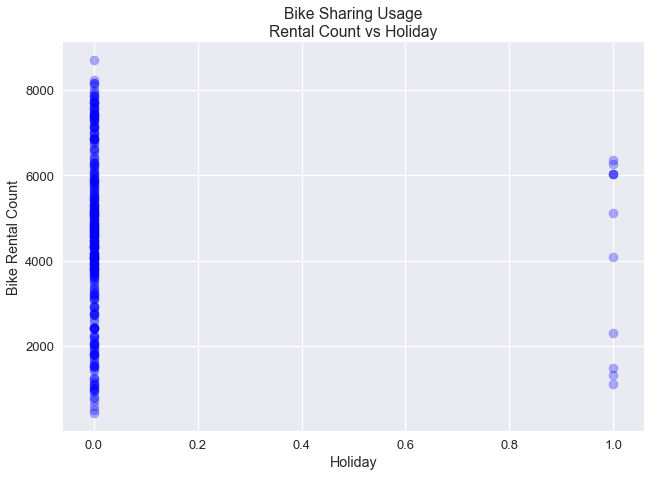

In [7]:
holiday = bike_train_df['holiday'].values

sns.set_context('talk')
plt.scatter(holiday, bike_count_train, color='blue', alpha=0.3)
plt.xlabel('Holiday')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Holiday')
plt.show()

Too few data point in Holiday to make any meaningful conclusion

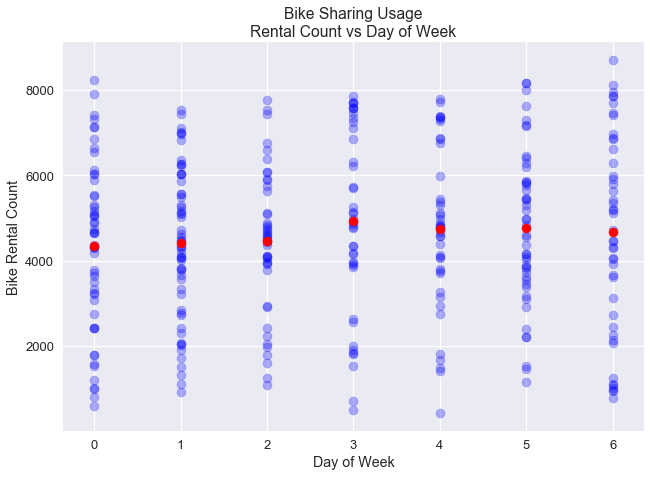

In [8]:
day_of_week = bike_train_df['day_of_week'].values

sns.set_context('talk')
plt.scatter(day_of_week, bike_count_train, color='blue', alpha=0.3)
for s in range(0, 7):
    plt.scatter(s, bike_count_train[day_of_week==s].mean(), color='red', label='mean')
plt.xlabel('Day of Week')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Day of Week')
plt.show()

The day of week doesn't seem to affect the number of bike rental

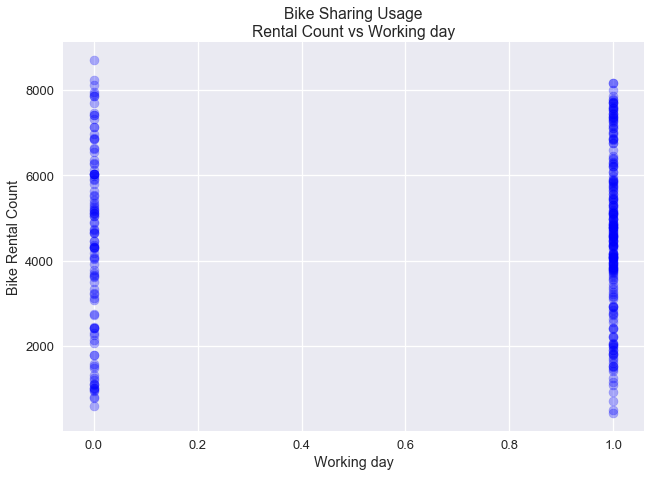

In [9]:
workingday = bike_train_df['workingday'].values

sns.set_context('talk')
plt.scatter(workingday, bike_count_train, color='blue', alpha=0.3)
plt.xlabel('Working day')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Working day')
plt.show()

Whether it is a working day or not doesn't seem to affect the number of bike rental

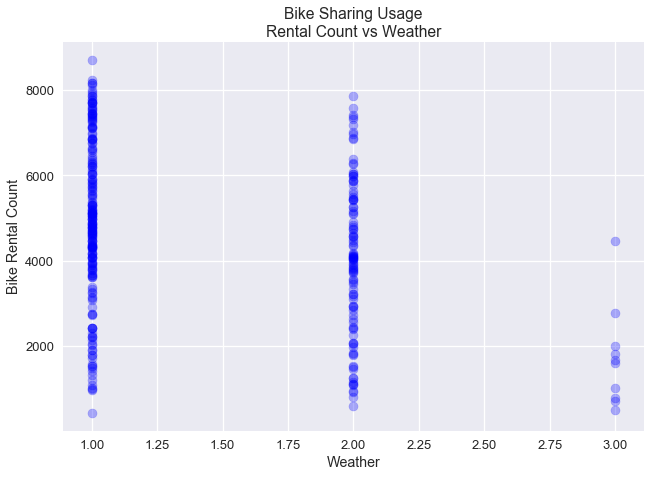

In [10]:
weather = bike_train_df['weather'].values

sns.set_context('talk')
plt.scatter(weather, bike_count_train, color='blue', alpha=0.3)
plt.xlabel('Weather')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Weather')
plt.show()

During better weather (1 and 2) there is more rental counts, but there is too few data in bad weather (3 or 4) to conclude.

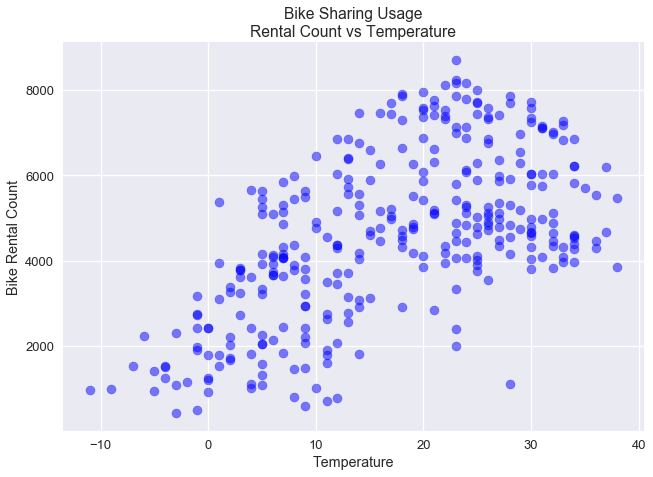

In [11]:
temp = bike_train_df['temp'].values

sns.set_context('talk')
plt.scatter(temp, bike_count_train, color='blue', alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Temperature')
plt.show()

The rental count is relatively higher in higher temperature (20-30) and lower in low temperature (<10)

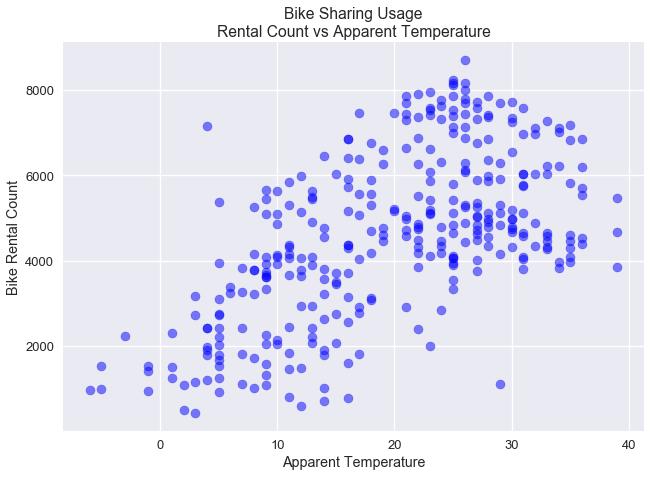

In [12]:
atemp = bike_train_df['atemp'].values

sns.set_context('talk')
plt.scatter(atemp, bike_count_train, color='blue', alpha=0.5)
plt.xlabel('Apparent Temperature')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Apparent Temperature')
plt.show()

The rental count is relatively higher in higher apparent temperature (20-30) and lower in low apparent temperature (<20)

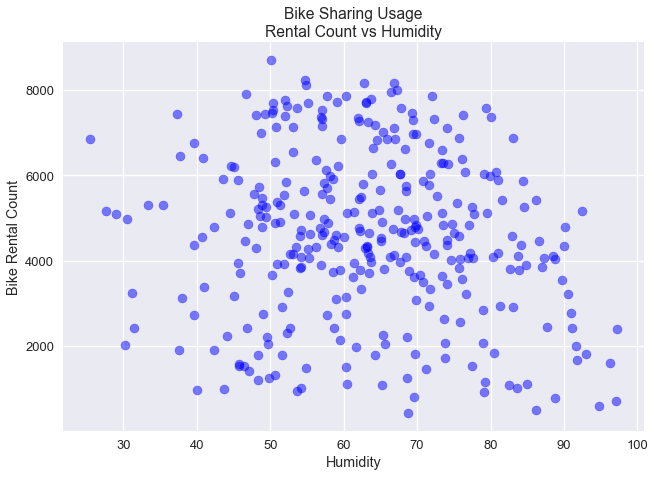

In [13]:
humidity = bike_train_df['humidity'].values

sns.set_context('talk')
plt.scatter(humidity, bike_count_train, color='blue', alpha=0.5)
plt.xlabel('Humidity')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Humidity')
plt.show()

The scatter plot looks pretty random - most likely humidity has very small effect on rental count

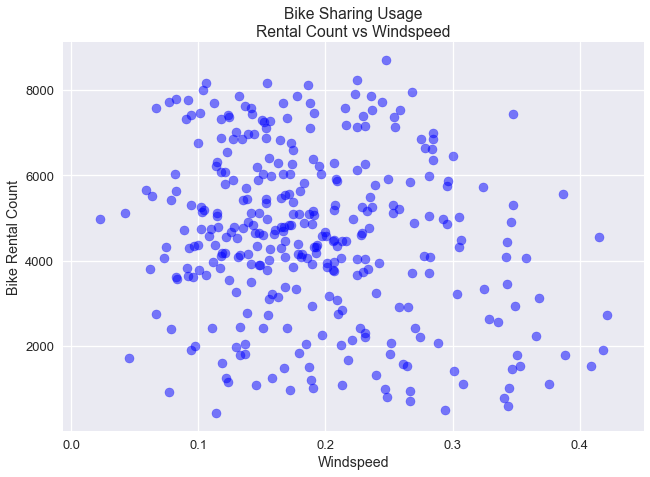

In [14]:
windspeed = bike_train_df['windspeed'].values

sns.set_context('talk')
plt.scatter(windspeed, bike_count_train, color='blue', alpha=0.5)
plt.xlabel('Windspeed')
plt.ylabel('Bike Rental Count')
plt.title('Bike Sharing Usage\nRental Count vs Windspeed')
plt.show()

The scatter plot looks pretty random - most likely the windspeed has very small effect on rental count

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [15]:
bike_train_df = pd.get_dummies(bike_train_df, columns = ['season', 'month', 'day_of_week', 'weather'])
bike_test_df = pd.get_dummies(bike_test_df, columns = ['season', 'month', 'day_of_week', 'weather'])
bike_train_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,...,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3
0,0,1,24.0,26.0,76.5833,0.118167,6073,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,1,15.0,19.0,73.3750,0.174129,6606,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,1,26.0,28.0,56.9583,0.253733,7363,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0.0,4.0,58.6250,0.169779,2431,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,1,23.0,23.0,91.7083,0.097021,1996,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [16]:
bike_train_df = bike_train_df.drop(['season_4', 'month_12', 'day_of_week_0'], axis=1)
bike_test_df = bike_test_df.drop(['season_4', 'month_12', 'day_of_week_0'], axis=1)
bike_train_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,...,month_11,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3
0,0,1,24.0,26.0,76.5833,0.118167,6073,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,1,15.0,19.0,73.3750,0.174129,6606,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,1,26.0,28.0,56.9583,0.253733,7363,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0.0,4.0,58.6250,0.169779,2431,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,23.0,23.0,91.7083,0.097021,1996,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [17]:
bike_train_df['temp'] = bike_train_df['temp'].apply(lambda t: (t-temp.mean())/temp.std())
bike_train_df['atemp'] = bike_train_df['atemp'].apply(lambda t: (t-atemp.mean())/atemp.std())
bike_train_df['humidity'] = bike_train_df['humidity'].apply(lambda h: (h-humidity.mean())/humidity.std())
bike_train_df['windspeed'] = bike_train_df['windspeed'].apply(lambda w: (w-windspeed.mean())/windspeed.std())

bike_test_df['temp'] = bike_test_df['temp'].apply(lambda t: (t-temp.mean())/temp.std())
bike_test_df['atemp'] = bike_test_df['atemp'].apply(lambda t: (t-atemp.mean())/atemp.std())
bike_test_df['humidity'] = bike_test_df['humidity'].apply(lambda h: (h-humidity.mean())/humidity.std())
bike_test_df['windspeed'] = bike_test_df['windspeed'].apply(lambda w: (w-windspeed.mean())/windspeed.std())

bike_train_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,...,month_11,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3
0,0,1,0.624743,0.651090,0.922058,-0.930164,6073,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,1,-0.180583,-0.054841,0.697907,-0.213825,6606,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,1,0.803704,0.852785,-0.449062,0.805143,7363,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,-1.522794,-1.567551,-0.332616,-0.269507,2431,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0.535262,0.348548,1.978781,-1.200843,1996,0,0,1,...,0,0,0,1,0,0,0,0,0,1


1. **Why can't they be directly used as predictors?**
> Because categorical attributes' (those with two or more categories) numbering has no numerical meanning (e.g. "Fall" in season has no connection to the numerical "3"). To use them as predictors, we should only use boolean (0 and 1) to indicate whether such category is presented in the data.
2. ** Why is it okay to not have a binary column for the $K_j$-th category? **
> Because the $K_j$-th category can be interpreted from the other columns
3. ** Why shouldn't we include the test set observations in computing the mean and SD? **
> Because the test set should be "unknown" and its information should not be used in any training purpose

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [18]:
X_train = sm.add_constant(bike_train_df.drop('count', axis=1).copy())
Y_train = bike_train_df['count'].copy()

In [19]:
MLR_result = OLS(Y_train, X_train).fit()

In [20]:
MLR_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Tue, 03 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        23:48:46   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3192.2092    338.813      9.422      0.000    2525.486    3858.933
holiday        -284.3563    398.982     -0.713      0.477   -1069.483     500.770
workingday      308.1531    165.413      1.863      0.063     -17.351     633.657
temp            924.3344    473.819      1.951      0.052      -8.058    1856.727
atemp           311.9618    429.337      0.727      0.468    -532.898    1156.822
humidity       -547.6638    113.029     -4.845      0.000    -770.085    -325.243
windspeed      -254.7369     80.644     -3.159      0.002    -413.431     -96.043
season_1      -1226.1865    506.763     -2.420      0.016   -2223.407    -228.966
season_2       -327.3575    573.373     -0.571      0.568   -1455.654     800.939
season_3       -193.3050    449.171     -0.430      0.667   -1077.194     690.584
month_1         118.8358    505.353      0.235      0.814    -875.611    1113.282
month_2         207.7759    516.216      0.402      0.688    -808.047    1223.599
month_3         358.0167    511.391      0.700      0.484    -648.310    1364.344
month_4         452.1849    657.792      0.687      0.492    -842.234    1746.604
month_5          53.0233    700.991      0.076      0.940   -1326.403    1432.450
month_6        -673.4271    696.142     -0.967      0.334   -2043.313     696.458
month_7       -1161.1512    701.261     -1.656      0.099   -2541.109     218.806
month_8        -657.6397    684.628     -0.961      0.338   -2004.868     689.588
month_9         523.9804    548.284      0.956      0.340    -554.945    1602.906
month_10        605.0867    439.844      1.376      0.170    -260.449    1470.623
month_11        231.5175    413.966      0.559      0.576    -583.094    1046.129
day_of_week_1  -123.7515    170.981     -0.724      0.470    -460.212     212.709
day_of_week_2  -195.2859    203.703     -0.959      0.338    -596.137     205.565
day_of_week_3   170.5113    213.789      0.798      0.426    -250.187     591.210
day_of_week_4    61.2560    206.213      0.297      0.767    -344.536     467.048
day_of_week_5   111.0669    198.877      0.558      0.577    -280.288     502.422
day_of_week_6   465.1450    269.154      1.728      0.085     -64.504     994.794
weather_1      1596.9180    198.428      8.048      0.000    1206.446    1987.390
weather_2      1580.3514    183.091      8.631      0.000    1220.060    1940.643
weather_3        14.9397    386.998      0.039      0.969    -746.605     776.485
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.            

In [21]:
X_test = sm.add_constant(bike_test_df.drop('count', axis=1).copy())
Y_test = bike_test_df['count'].copy()

In [56]:
Y_train_pred = MLR_result.predict(X_train)
r2_train = r2_score(Y_train, Y_train_pred)

Y_test_pred = MLR_result.predict(X_test)
r2_test = r2_score(Y_test, Y_test_pred)

print("Training R^2: %.5f\nTesting R^2: %.5f" % (r2_train, r2_test))

Training R^2: 0.57613
Testing R^2: 0.24934


In [23]:
MLR_result.pvalues[MLR_result.pvalues < 0.05]

const        1.182848e-18
humidity     2.020827e-06
windspeed    1.744235e-03
season_1     1.612408e-02
weather_1    1.930751e-14
weather_2    3.489795e-16
dtype: float64

**1. Which among the predictors have a positive correlation with the number of bike rentals?**
> Humidity, Windspeed, Season 1 (Jan), and weathers 1 and 2

**2. Does the day of a week have a relationship with bike rentals?**
> Based on the p-value result - no

**3. Does the month influence the bike rentals?**
> Based on the p-value result - no

**4. What effect does a holiday have on  bike rentals?**
> Based on the p-value result - whether it is a holiday has no effect on bike rental

**5. Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.**
> Yes - the coefficient for `temp` is roughly 3 times of the `atemp`. This could be due to the fact that temperature, instead of apparent temperature, is what potential renters use to judge whether it is suitable for biking.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [24]:
corr = bike_train_df.corr()

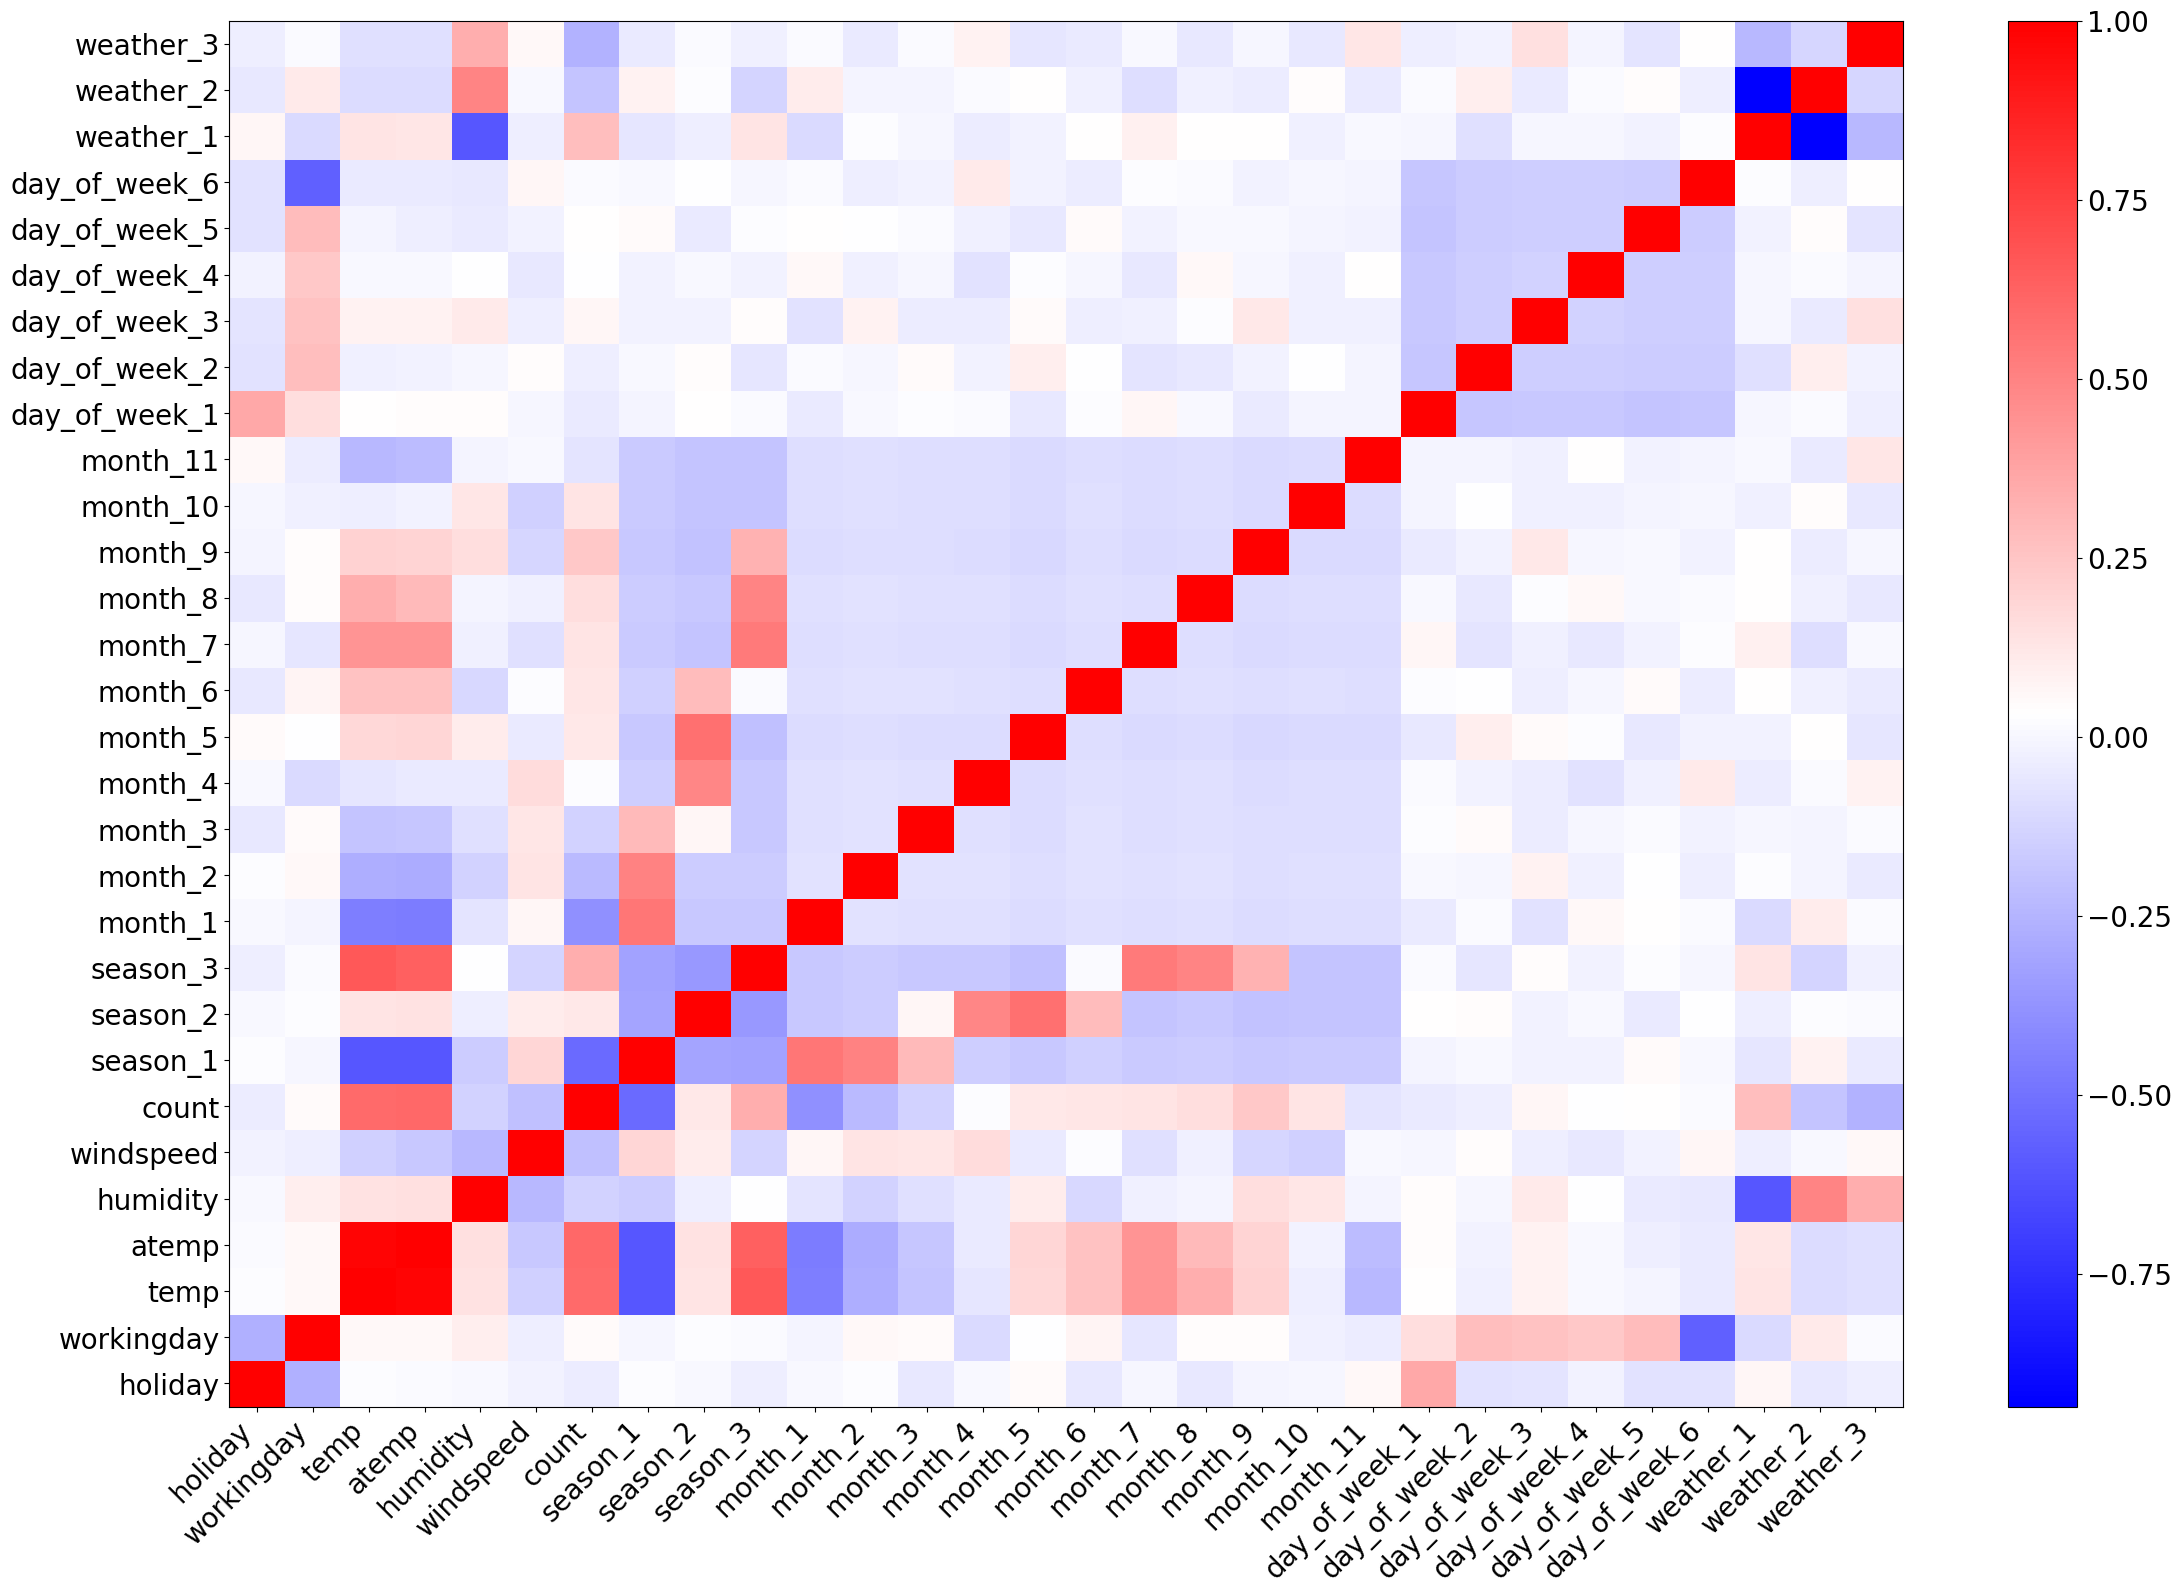

In [25]:
sns.reset_defaults()

plt.figure(figsize=(27,18))
plt.xticks(np.arange(len(bike_train_df.columns))+0.5, bike_train_df.columns, rotation=45, \
           fontsize=20, horizontalalignment="right")
plt.yticks(np.arange(len(bike_train_df.columns))+0.5, bike_train_df.columns, fontsize=20)
pc = plt.pcolor(corr, cmap=plt.cm.bwr)
cbar = plt.colorbar(pc)
cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels(), fontdict={"size": 20})

plt.show()

Some of the predictors are highly correlated to each others:

For example, workingday and holiday are obviously related to each other.
Seasons, months and temperature are related to each others.
Weather and humidity are another pair with high correlation

So these predictors do not fall into natural group as some of them are highly correlated

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




### Forward Selection ###

In [41]:
all_predictors = bike_train_df.drop('count', axis=1).columns.tolist()
predictors = [([], 0)] # (predictors, bic)

for k in range(1, len(all_predictors)+1):
    best_k_minus_1 = predictors[-1][0]
    
    new_predictors = list(set(all_predictors) - set(best_k_minus_1))
    bics = []
    
    for predictor in new_predictors:
        k_predictors = best_k_minus_1 + [predictor]
        k_X_train = sm.add_constant(bike_train_df[k_predictors])
        Y_train = bike_train_df['count']
        
        k_MLR_result = OLS(Y_train, k_X_train).fit()
        bics.append(k_MLR_result.bic)
        #print(k_predictors, k_MLR_result.bic)
    
    best_k = best_k_minus_1 + [new_predictors[np.argmin(bics)]]
    predictors.append((best_k, np.min(bics)))

In [48]:
best_predictor_set = sorted(predictors, key=lambda p: p[1])[1]
print("The best predictors set is: %s with BIC=%.3f" % (best_predictor_set[0], best_predictor_set[1]))

The best predictors set is: ['atemp', 'humidity', 'season_1', 'weather_3', 'month_9', 'month_10', 'windspeed', 'month_7'] with BIC=5737.502


In [57]:
best_X_train = sm.add_constant(bike_train_df[best_predictor_set[0]])
Y_train = bike_train_df['count']

best_MLR_model = OLS(Y_train, best_X_train)
best_MLR_result = best_MLR_model.fit()

Y_train_pred = best_MLR_result.predict(best_X_train)
r2_train = r2_score(Y_train, Y_train_pred)

best_X_test = sm.add_constant(bike_test_df[best_predictor_set[0]])
Y_test = bike_test_df['count']

Y_test_pred = best_MLR_result.predict(best_X_test)
r2_test = r2_score(Y_test, Y_test_pred)

print("R^2 score for training set: %.3f\nR^2 score for testing set: %.3f" % (r2_train, r2_test))

R^2 score for training set: 0.548
R^2 score for testing set: 0.266


### Backward Selection ###

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [28]:
# your code here

your answers here